In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [75]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [77]:
# train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
# test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
# submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
data = pd.read_csv("./all_sentences.csv")
data.head()

sentences  \
0  The complexity of intracanal infection requires treatment with a broad  spectrum  antibacterial such as sodium  hypochlorite.   
1                                Molecular technology enables identification of microorgan- isms without the need for culturing.   
2          This enables other bacterial species that would not have survived alone to attach to, and form part of the biofilm.     
3                                             If no treatment is provided, the bacteria eventually invade and colonise the pulp.   
4                     If rubber dam is not used, or poor fitting temporary restorations are placed, microleakage can also occur.   

   is_causal  
0          0  
1          0  
2          0  
3          0  
4          0

# EDA 

In [78]:
data =data.rename({'sentences':'text'}, axis=1)
data = data.rename({'is_causal':'target'}, axis=1)

data.head()

text  \
0  The complexity of intracanal infection requires treatment with a broad  spectrum  antibacterial such as sodium  hypochlorite.   
1                                Molecular technology enables identification of microorgan- isms without the need for culturing.   
2          This enables other bacterial species that would not have survived alone to attach to, and form part of the biofilm.     
3                                             If no treatment is provided, the bacteria eventually invade and colonise the pulp.   
4                     If rubber dam is not used, or poor fitting temporary restorations are placed, microleakage can also occur.   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

<AxesSubplot:ylabel='target'>

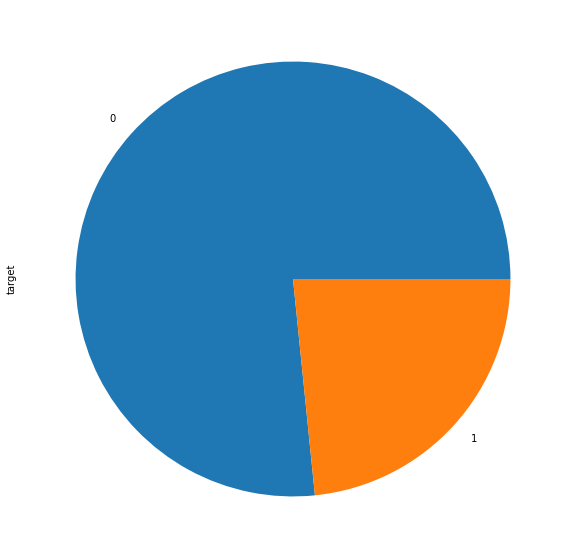

In [79]:
rcParams["figure.figsize"] = 10,10
data["target"].value_counts().plot(kind="pie")

In [80]:
real_text = data[data["target"]==1]
false_text = data[data["target"]==0]

In [81]:
print(real_text.shape)
print(false_text.shape)

(920, 2)
(3013, 2)


# WordCloud for real data

In [82]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


In [83]:
# real_data_text = real_text.text
# generate_word_cloud(real_data_text)

# WordCloud for False text

In [84]:
# false_data_text = false_text.text
# generate_word_cloud(false_data_text)

# Simple pre-processing 

**The data set contains 0 as more lable and 1 has little less than 0**

# some pre-preocessing needed for bert model

In [85]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



# creating a bert model based on tensorflow hub

In [86]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(200, activation='sigmoid')(clf_output)
    out1 = Dense(1,activation='sigmoid')(out)
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out1)
    model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

tf.gfile = tf.io.gfile


# initializing the vocab file and tokenizer for bert model

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text.values, data.target.values, test_size=0.2, random_state=42, stratify=data.target.values)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
import tokenization

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)


In [16]:

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case=True)

data_input = bert_encode(X_train, tokenizer, max_len=160)
data_labels = y_train

test_input = bert_encode(X_test, tokenizer, max_len=160)
test_labels = y_test


In [17]:
# model = build_model(bert_layer, max_len=160)
# model.summary()


In [18]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# !export CUDA_VISIBLE_DEVICE=1


In [19]:
# checkpoint_filepath = '/tmp/checkpoint'

# checkpoint = ModelCheckpoint('model_2.h5', monitor='val_loss', save_best_only=True)

# train_history = model.fit(
#     data_input, data_labels,
#     validation_split=0.2,
#     epochs=5,
#     callbacks=[checkpoint],
#     batch_size=16,
#     use_multiprocessing=True
# )

 tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [20]:

tf.gfile = tf.io.gfile

model = build_model(bert_layer, max_len=160)

model.load_weights('model.h5')
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [21]:
# temp_model = tf.keras.models.load_model('model.h5')

In [22]:
print('evaluate model on testing set')
results = model.evaluate(test_input, test_labels)

print('test loss, test acc:', results)


evaluate model on testing set
25/25 [==============================] - 144s 6s/step - loss: 0.1197 - accuracy: 0.9708
test loss, test acc: [0.11971169710159302, 0.9707750678062439]


In [23]:
# pruned_model = build_model(bert_layer, max_len=160)
# pruned_model.load_weights('pruned.h5')

In [24]:
# print('evaluate pruned model on testing set')
# results = pruned_model.evaluate(test_input, test_labels)

# print('test loss, test acc:', results)


In [25]:

pred = model.predict(test_input)

In [26]:
labels=['0','1']

In [27]:
from sklearn.metrics import classification_report


In [28]:
y_pred = [ 0 if x[0] <0.5 else 1 for x in pred]
from sklearn.metrics import accuracy_score
report = classification_report(test_labels, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       603
           1       0.98      0.90      0.93       184

    accuracy                           0.97       787
   macro avg       0.97      0.95      0.96       787
weighted avg       0.97      0.97      0.97       787



In [29]:

m_acc = tf.keras.metrics.Accuracy()
m_acc.update_state(test_labels, y_pred)
acc =m_acc.result().numpy()

m = tf.keras.metrics.Recall()
m.update_state(test_labels, y_pred)
recall =m.result().numpy()

m = tf.keras.metrics.Precision()
m.update_state(test_labels, y_pred)
precision = m.result().numpy()
acc
print(f'model evaluation: precision: {precision} recall: {recall} accuracy = {acc}')

model evaluation: precision: 0.976331353187561 recall: 0.89673912525177 accuracy = 0.9707750678062439


In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


X = bert_encode(data.text.values, tokenizer, max_len=160)
Y = data.target.values




In [ ]:

PRED = model.predict(X)

In [ ]:
y_pred = [ 0 if x[0] <0.5 else 1 for x in PRED]
from sklearn.metrics import accuracy_score
score = accuracy_score(Y, y_pred)
print(score)
##model to big


# pred = pred

In [ ]:

m_acc = tf.keras.metrics.Accuracy()
m_acc.update_state(Y, y_pred)
m_acc.result().numpy()

m = tf.keras.metrics.Recall()
m.update_state(Y, y_pred)
m.result().numpy()

m = tf.keras.metrics.Precision()
m.update_state(Y, y_pred)
m.result().numpy()


In [ ]:
casal_text = [x  for (x,y) in zip( data['text'], y_pred ) if y == 1]

In [ ]:
len(casal_text)

In [ ]:
model.summary()

In [ ]:
model.layers[3]